# 8. Non-Daily Data 非日数据
## 8.1 子日数据
Prophet可以通过在ds列中传递一个带有时间戳的dataframe来对时间序列进行**子日（Sub-daily）**观测。时间戳的格式应该是YYYY-MM-DD - HH:MM:SS。当使用子日数据时，日季节性将自动匹配。在这里，我们用5分钟的分辨率数据集(约塞米蒂的每日温度)对Prophet进行数据匹配:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


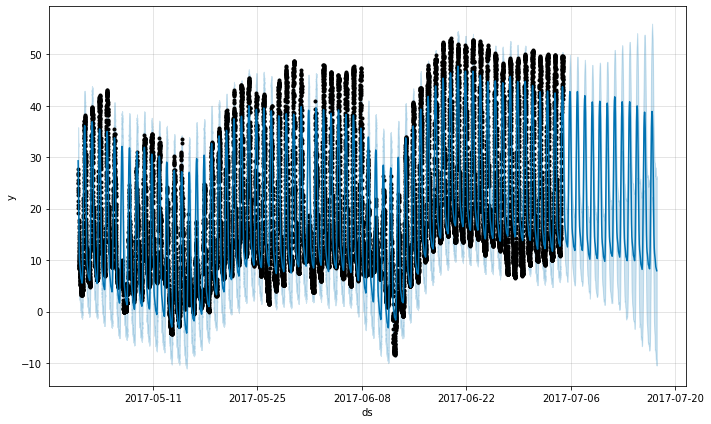

In [3]:
from fbprophet import Prophet
import pandas as pd

df = pd.read_csv('examples/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)  # 调整稀疏先验的程度
future = m.make_future_dataframe(periods=300, freq='H')  # 300秒就是5分钟
fcst = m.predict(future)
pd.plotting.register_matplotlib_converters()
fig = m.plot(fcst)

成分图中的季节性：

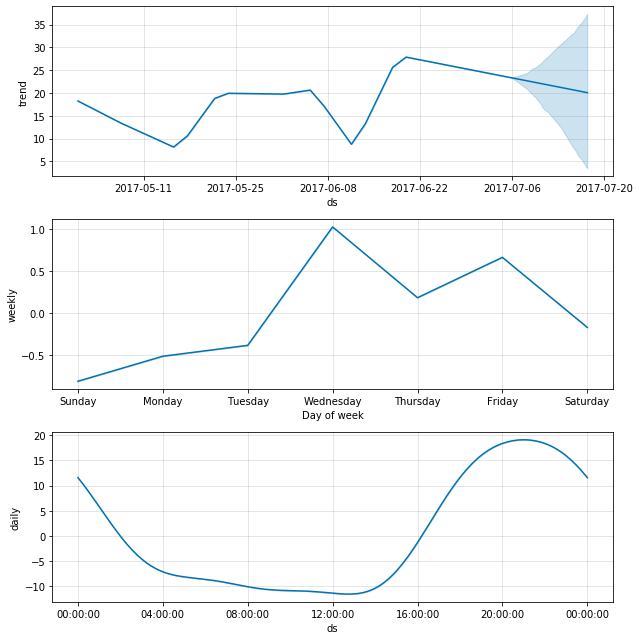

In [4]:
fig = m.plot_components(fcst)

## 8.2 有规则间隔的数据
假设上面的数据集只有每天早上6点之前的观测值:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


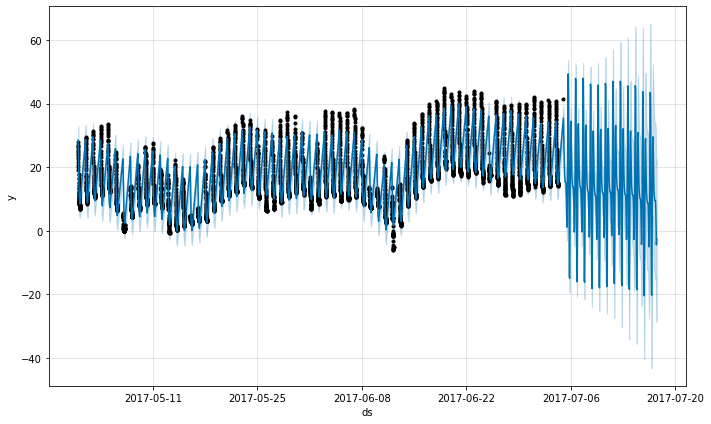

In [5]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
# 只保留每天早上6点之前的数据
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

这个预测看起来很差，未来的波动比历史上看到的要大得多。这里的问题是，我们将每天的循环安排在一个时间序列中，这个时间序列中只有一天的一部分数据(12a到6a)。**因此，每天的季节性在一天剩下的时间里是不受约束的，估计也不准确**。解决方案是只对有历史数据的时间窗进行预测。这里，这意味着限制未来dataframe的时间（从12a到6a）:

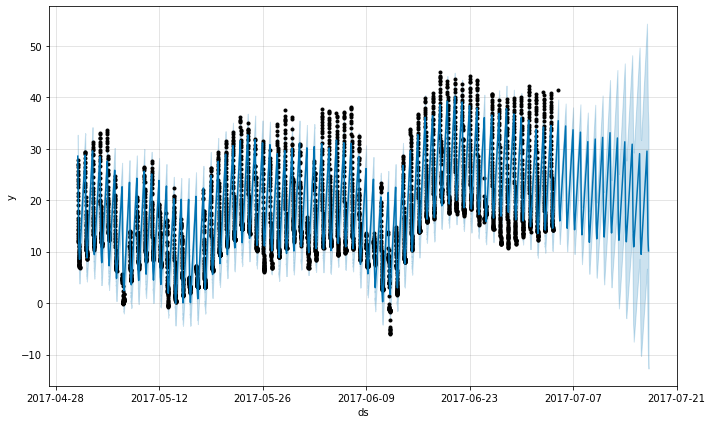

In [6]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

同样的原理也适用于数据中有规则间隔的其他数据集。例如，**如果历史只包含工作日，那么应该只对工作日进行预测**，因为不会很好地估计每周的季节性。
## 8.3 月数据
可以使用Prophet来匹配每月的数据。然而，Prophet 的基本模型是连续时间的，这意味着如果将模型与每月的数据相匹配，然后要求每天的预测，我们会得到奇怪的结果。

下面使用美国零售业销售量数据来预测未来 10 年的情况：

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


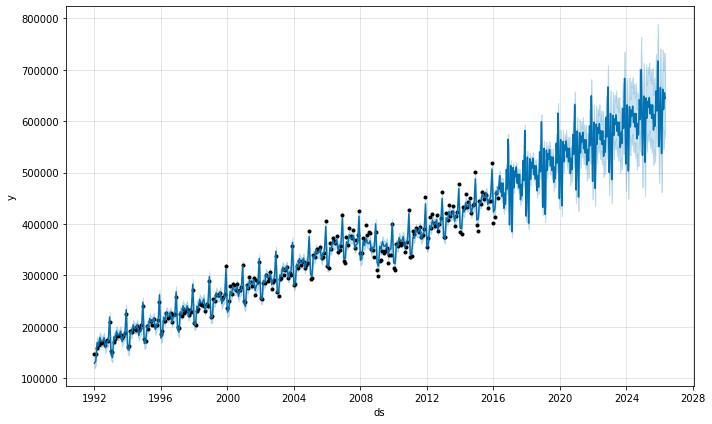

In [7]:
df = pd.read_csv('examples/example_retail_sales.csv')
m = Prophet().fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

预测结果看起来非常杂乱，原因正是在于这个特殊的数据集使用的是**月数据**。当我们拟合年度效应时，只有每个月第一天的数据，而且对于其他天的周期效应是不可测且过拟合的。当你使用 Prophet 拟合月度数据时，可以通过在 **make_future_dataframe** 中传入频率参数只做月度的预测。

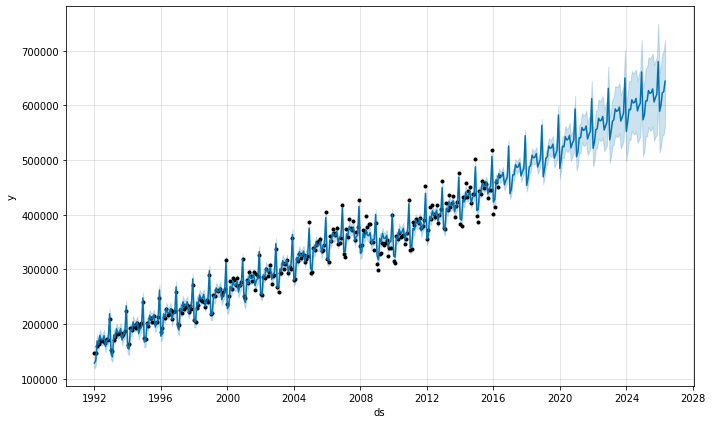

In [8]:
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)